In [1]:
import numpy as np
from importlib import reload
import matplotlib.pyplot as plt
import vaetorch
%matplotlib inline

import torch
import torch.nn as nn
from torchvision.datasets import FashionMNIST

from spiral import spiral_pts

In [2]:
_pts, _, _labs = spiral_pts(3, 100)

reload(vaetorch)

<module 'vaetorch' from '/Users/lorenzo/GitHub/VAEMusings/vaetorch.py'>

In [3]:
_data = vaetorch.make_tensor_dataset(_pts)
_labels = vaetorch.make_tensor_dataset(_labs)
_joint = vaetorch.TProdDataset(_labels, _data)

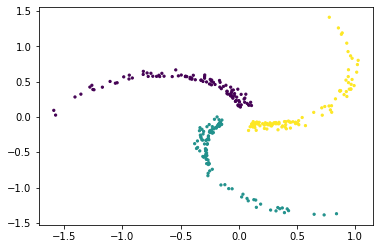

In [4]:
plt.scatter(_pts[:, 0], _pts[:, 1], s=5, c=_labs)

In [38]:
_cvae.sample_generative(_labels[:3][0])

tensor([[-0.1371,  0.6634],
        [ 0.4208,  0.2624],
        [ 0.2174,  0.1370]], grad_fn=<AddBackward0>)

In [65]:
def plot_conditional_model(model, possible_labels, data, n_samples=100, seed=321):
    torch.manual_seed(seed)
    np.random.seed(seed)
    _labs = np.random.choice(possible_labels, n_samples).reshape(-1, 1)
    labels = torch.tensor(_labs,
                          dtype=torch.float32)
#     latent_dims = model.latent_dims
#     zs = torch.randn(n_samples, latent_dims)
#     xs = model.generator.sample(zs).detach().numpy()
    xs = model.sample_generative(labels).detach().numpy()
    fig, axs = plt.subplots(1, 2, figsize=(10, 5))
    axs[0].scatter(xs[:, 0], xs[:, 1], s=5, c="g")
    axs[0].set_title("Sampled")
    axs[1].scatter(data[:, 0], data[:, 1], s=5, c="k")
    axs[1].set_title("Original")
    return {"figure": fig, "sampled": xs, "conditions": _labs}

In [80]:
reload(vaetorch)

def make_vae(n_mc=7):
    condition_dims = 1
    latent_dims = 2
    visible_dims = 2
    prior_μ_arch = {
        "constructor": "ffwdnn",
        "input_dims": condition_dims,
        "layer_units": [10, 10, 10, latent_dims],
        "activations": ["relu", "relu", "relu", "identity"],
        "name": "prior_μ",
    }
    prior_σ_arch = {
        "constructor": "ffwdnn",
        "input_dims": condition_dims,
        "layer_units": [3, latent_dims],
        "activations": ["relu", "none"],
        "name": "prior_σ",
    }
    prior_architecture = {
        "μ": prior_μ_arch,
        "log_σ": prior_σ_arch,
    }
    generator_μ_arch = {
        "constructor": "collidernn",
        "left_input_dims": condition_dims,
        "right_input_dims": latent_dims,
        "layer_units": [100, 100, 100, visible_dims],
        "activations": ["relu", "relu", "relu", "identity"],
        "name": "gen_μ",
    }
    generator_σ_arch = {
        "constructor": "collidernn",
        "left_input_dims": condition_dims,
        "right_input_dims": latent_dims,
        "layer_units": [3, visible_dims],
        "activations": ["relu", "none"],
        "name": "gen_σ",
    }
    generator_architecture = {"μ": generator_μ_arch,
                              "log_σ": generator_σ_arch,
                             }
    recognition_μ_arch = {
        "constructor": "collidernn",
        "left_input_dims": condition_dims,
        "right_input_dims": visible_dims,
        "layer_units": [100, 100, 100, latent_dims],
        "activations": ["relu", "relu", "relu", "identity"],
        "name": "rec_μ",
    }
    recognition_σ_arch = {
        "constructor": "collidernn",
        "left_input_dims": condition_dims,
        "right_input_dims": visible_dims,
        "layer_units": [3, latent_dims],
        "activations": ["relu", "none"],
        "name": "rec_σ",
    }
    recognition_architecture = {"μ": recognition_μ_arch,
                              "log_σ": recognition_σ_arch,
                             }
    architectures = {
        "vae_family": "cvae",
        "prior": prior_architecture,
        "generator": generator_architecture,
        "recognition": recognition_architecture,
        "optimizer": "adam",
        "n_mc_samples": n_mc,
        "optimizer_options": {"lr": 0.01}
    }
    return vaetorch.make_vae(**architectures)

In [81]:
_cvae = make_vae()

Adding prior
Adding generator
Adding recognition


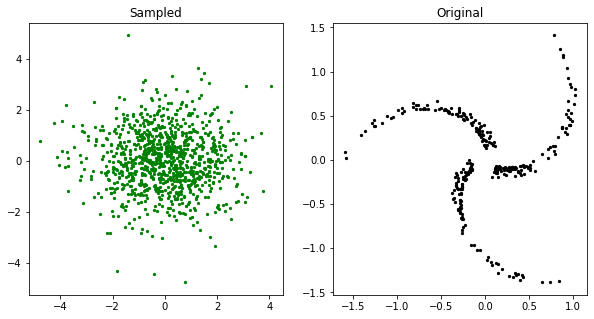

In [82]:
_fig_in = plot_conditional_model(_cvae, [0, 1, 2], _pts, n_samples=1000)

In [83]:
_cvae.fit(_joint, batch_size=128, epochs=100)

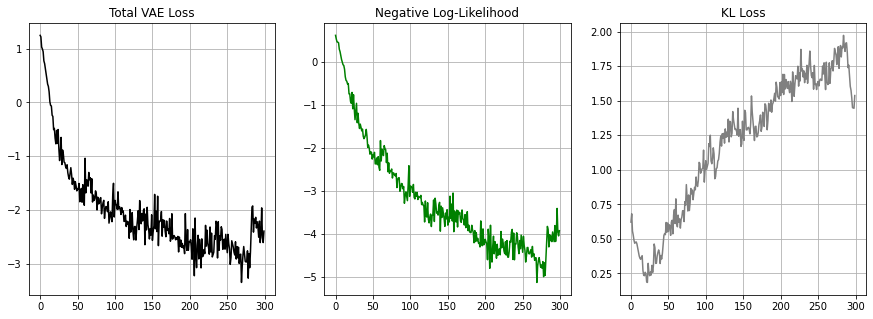

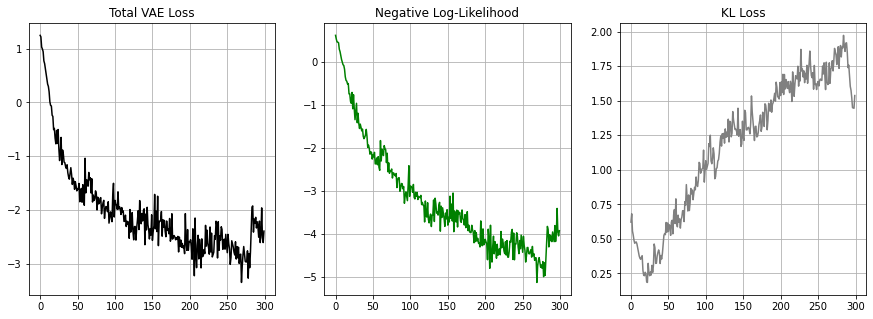

In [84]:
_cvae.plot_losses()

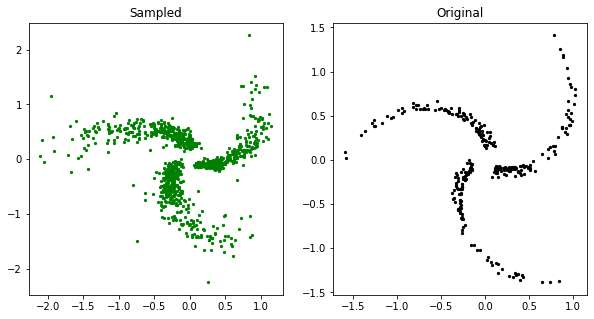

In [85]:
_fig_in = plot_conditional_model(_cvae, [0, 1, 2], _pts, n_samples=1000)

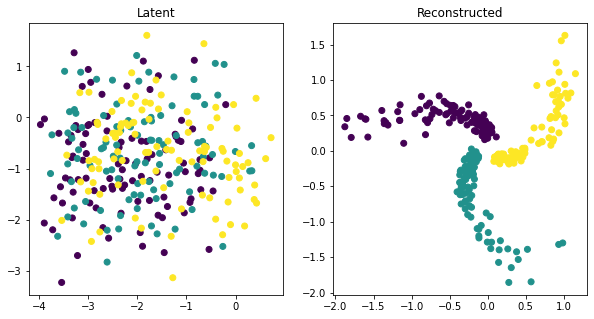

In [87]:
_cvae.plot_latent(_labs, _pts, labels=_labs)